<a href="https://colab.research.google.com/github/SheidaAbedpour/MNIST-Neural-Networks/blob/main/MNIST_MLP_HyperTunning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

import time

import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Subset
from torch.utils.data import random_split

from torch.optim.lr_scheduler import ReduceLROnPlateau

import tensorboard
from torch.utils.tensorboard import SummaryWriter

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# MNIS Dataset
train_dataset = datasets.MNIST(root='./data',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='./data',
                              train=False,
                              transform=transforms.ToTensor(),
                              download=True)



# split train_data to validation and train
train_size = int(0.8 * len(train_dataset))
validation_size = len(train_dataset) - train_size
train_dataset, validation_dataset = random_split(train_dataset, [train_size, validation_size])



# Load Data
def load_data(batch_size=64):
  train_data = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

  test_data = DataLoader(dataset=test_dataset,
                        batch_size=batch_size,
                        shuffle=False)

  validation_data = DataLoader(dataset=validation_dataset,
                              batch_size=batch_size,
                              shuffle=False)

  return train_data, test_data, validation_data

In [12]:
class MLP(nn.Module):
    def __init__(self, in_features, out_features, hidden_sizes, hidden_activations, dropout_rates=None, batch_norm=False):
        super(MLP, self).__init__()
        self.dropout_rates = dropout_rates if dropout_rates is not None else [0.0] * len(hidden_sizes)
        self.batch_norm = batch_norm
        self.model = self.get_model(in_features, out_features, hidden_sizes, hidden_activations)

    def get_activation(self, name):
        activations = {
            'relu': nn.ReLU(),
            'sigmoid': nn.Sigmoid(),
            'tanh': nn.Tanh(),
            'leaky_relu': nn.LeakyReLU()
        }
        return activations[name]

    def get_model(self, in_features, out_features, hidden_sizes, hidden_activations):
        layers = [nn.Flatten()]

        input_dim = in_features
        for i in range(len(hidden_sizes)):
            layers.append(nn.Linear(input_dim, hidden_sizes[i]))
            if self.batch_norm:
                layers.append(nn.BatchNorm1d(hidden_sizes[i]))
            layers.append(self.get_activation(hidden_activations[i]))
            if self.dropout_rates[i] > 0.0:
                layers.append(nn.Dropout(self.dropout_rates[i]))
            input_dim = hidden_sizes[i]

        layers.append(nn.Linear(input_dim, out_features))

        model = nn.Sequential(*layers)
        return model

    def get_optimizer(self, name, lr, momentum=0.9):
        optimizers = {
            'SGD': torch.optim.SGD(params=self.model.parameters(), lr=lr, momentum=momentum),
            'Adam': torch.optim.Adam(params=self.model.parameters(), lr=lr),
            'RMSprop': torch.optim.RMSprop(params=self.model.parameters(), lr=lr)
        }
        return optimizers[name]

    def get_criterion(self, name):
        criteria = {
            'CrossEntropyLoss': nn.CrossEntropyLoss()
        }
        return criteria[name]

    def train_model(self, train_data, validation_data, optimizer_name,
                    lr, num_epochs, convergence_threshold=1e-6, lambda_reg=0.0001):

        print("Training Started")

        model = self.model.to(device)
        criterion = self.get_criterion("CrossEntropyLoss")
        optimizer = self.get_optimizer(optimizer_name, lr)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

        num_batches = len(train_data)
        train_losses = []
        val_losses = []
        train_accs = []
        val_accs = []

        best_val_loss = float('inf')
        patience = 5
        wait = 0

        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            correct_train = 0
            total_train = 0

            for i, (images, labels) in enumerate(train_data):
                images, labels = images.to(device), labels.to(device)

                # Forward pass
                outputs = model(images)

                # Compute loss
                loss = criterion(outputs, labels)
                l2_reg_loss = sum(torch.norm(param) ** 2 for param in model.parameters())
                loss += lambda_reg * l2_reg_loss

                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                # Calculate training accuracy
                _, predicted = torch.max(outputs, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

            train_accuracy = correct_train / total_train
            train_accs.append(train_accuracy)

            # Validation loop
            val_loss = 0.0
            correct_val = 0
            total_val = 0

            model.eval()
            with torch.no_grad():
                for images, labels in validation_data:
                    images, labels = images.to(device), labels.to(device)

                    # Forward pass
                    outputs = model(images)

                    # Compute loss
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()

                    # Calculate validation accuracy
                    _, predicted = torch.max(outputs, 1)
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()

                val_accuracy = correct_val / total_val
                val_accs.append(val_accuracy)


            # Early stopping and convergence check
            if (val_loss / len(validation_data)) < best_val_loss:
                best_val_loss = val_loss / len(validation_data)
                wait = 0
            else:
                if ((val_loss / len(validation_data)) - best_val_loss) < 1e-10:
                    wait += 1
                if wait >= patience:
                    print(f'Early stopped in epoch {epoch + 1}/{num_epochs}')
                    break

            if epoch > 1:
                pre_loss = train_losses[-1]
                if abs(pre_loss - running_loss) < convergence_threshold:
                    print(f'Convergence in epoch {epoch + 1}/{num_epochs}')
                    break


            current_lr = optimizer.param_groups[0]['lr']
            print(f'Epoch {epoch + 1}/{num_epochs}\t Training Loss: {running_loss / len(train_data):.4f}, Training Acc: {train_accuracy:.4f}, Validation Loss: {val_loss / len(validation_data):.4f}, Validation Acc: {val_accuracy:.4f}, lr: {current_lr}, reg: {lambda_reg}')
            train_losses.append(running_loss / len(train_data))
            val_losses.append(val_loss / len(validation_data))

            # Update the learning rate
            scheduler.step(running_loss / len(train_data))

        print("Training finished")
        return train_losses, val_losses, train_accs, val_accs

    def test_model(self, test_data):
        model = self.model.to(device)
        model.eval()

        true_labels = []
        predicted_labels = []
        total = 0
        correct = 0

        with torch.no_grad():
            for images, labels in test_data:
                images, labels = images.to(device), labels.to(device)

                # Forward pass
                outputs = model(images)

                # Get the predicted class
                _, predicted = torch.max(outputs, dim=1)

                total += labels.shape[0]
                correct += (predicted == labels).sum().item()

                true_labels.extend(labels.cpu().numpy())
                predicted_labels.extend(predicted.cpu().numpy())

        acc = 100 * correct / total
        return acc, true_labels, predicted_labels


In [113]:
def plot_train_val_loss(train_losses, val_losses):
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.yscale('log')
    plt.legend()

def plot_confusion_matrix(true_labels, predicted_labels):
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')

def plot_train_val_acc(train_accs, val_accs):
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

def plot_accuracy_and_loss(all_train_accs, all_val_losses, num_epochs, model_names):
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    # Define the colormap
    colors = cm.tab20.colors

    # Plot for accuracy
    for i in range(len(all_train_accs)):
        color = colors[i % len(colors)]
        axs[0].plot(range(1, num_epochs + 1), all_train_accs[i], label=f"Model {model_names[i]} (Train)", color=color)

    axs[0].set_title('Accuracy of all Models')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()
    axs[0].grid(True)

    # Plot for loss
    for i in range(len(all_val_losses)):
        color = colors[i % len(colors)]
        axs[1].plot(range(1, num_epochs + 1), all_val_losses[i], label=f"Model {model_names[i]} (Validation)", color=color)

    axs[1].set_title('Loss of all Models')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()


In [18]:
batch_size = 128
in_features = 28 * 28
out_features = 10
hidden_sizes_try = [
    [128],
    [128],
    [128],
    [128, 128],
    [128, 128, 128]
]

hidden_activations_try = [
    ["relu"],
    ["tanh"],
    ["sigmoid"],
    ["relu", "relu"],
    ["relu", "relu", "relu"]
]

dropout_rates = [
    [0],
    [0],
    [0],
    [0.0, 0.0],
    [0.0, 0.0, 0.0]
]

batch_norm = False

optimizer_name = "Adam"
learning_rate = 1e-4
num_epochs = 15
convergence_threshold = 1e-6
lambda_reg = 1e-8

tiny_train_dataset = Subset(train_dataset, range(5000))
tiny_val_dataset = Subset(validation_dataset, range(1250))

tiny_train = DataLoader(dataset=tiny_train_dataset, batch_size=batch_size, shuffle=True)
tiny_val = DataLoader(dataset=tiny_val_dataset, batch_size=int(batch_size/4), shuffle=False)


all_train_losses = []
all_val_losses = []
all_train_accs = []
all_val_accs = []
model_names = []


for i, (hidden_activations, hidden_sizes, dropout_rate) in enumerate(zip(hidden_activations_try, hidden_sizes_try, dropout_rates)):
      model_name = f"Model_{i+1}_{'_'.join(map(str, hidden_activations))}_{'_'.join(map(str, hidden_sizes))}"
      model_names.append(model_name)

      model1 = MLP(in_features, out_features, hidden_sizes, hidden_activations,
                   dropout_rate, batch_norm)

      print(f'model: {model_name}')
      train_losses, val_losses, train_accs, val_accs = model1.train_model(
                                                        train_data=tiny_train,
                                                        validation_data=tiny_val,
                                                        optimizer_name=optimizer_name,
                                                        lr=learning_rate,
                                                        num_epochs=num_epochs,
                                                        convergence_threshold=convergence_threshold,
                                                        lambda_reg=lambda_reg)

      all_train_losses.append(train_losses)
      all_val_losses.append(val_losses)
      all_train_accs.append(train_accs)
      all_val_accs.append(val_accs)


model: Model_1_relu_128
Training Started
Epoch 1/15	 Training Loss: 2.2021, Training Acc: 0.3896, Validation Loss: 2.0955, Validation Acc: 0.5968, lr: 0.0001, reg: 1e-08
Epoch 2/15	 Training Loss: 1.9605, Training Acc: 0.6830, Validation Loss: 1.8493, Validation Acc: 0.6960, lr: 0.0001, reg: 1e-08
Epoch 3/15	 Training Loss: 1.6849, Training Acc: 0.7362, Validation Loss: 1.5915, Validation Acc: 0.7344, lr: 0.0001, reg: 1e-08
Epoch 4/15	 Training Loss: 1.4413, Training Acc: 0.7728, Validation Loss: 1.3672, Validation Acc: 0.7696, lr: 0.0001, reg: 1e-08
Epoch 5/15	 Training Loss: 1.2246, Training Acc: 0.8016, Validation Loss: 1.1866, Validation Acc: 0.7968, lr: 0.0001, reg: 1e-08
Epoch 6/15	 Training Loss: 1.0615, Training Acc: 0.8226, Validation Loss: 1.0442, Validation Acc: 0.8144, lr: 0.0001, reg: 1e-08
Epoch 7/15	 Training Loss: 0.9353, Training Acc: 0.8336, Validation Loss: 0.9371, Validation Acc: 0.8264, lr: 0.0001, reg: 1e-08
Epoch 8/15	 Training Loss: 0.8403, Training Acc: 0.8448,

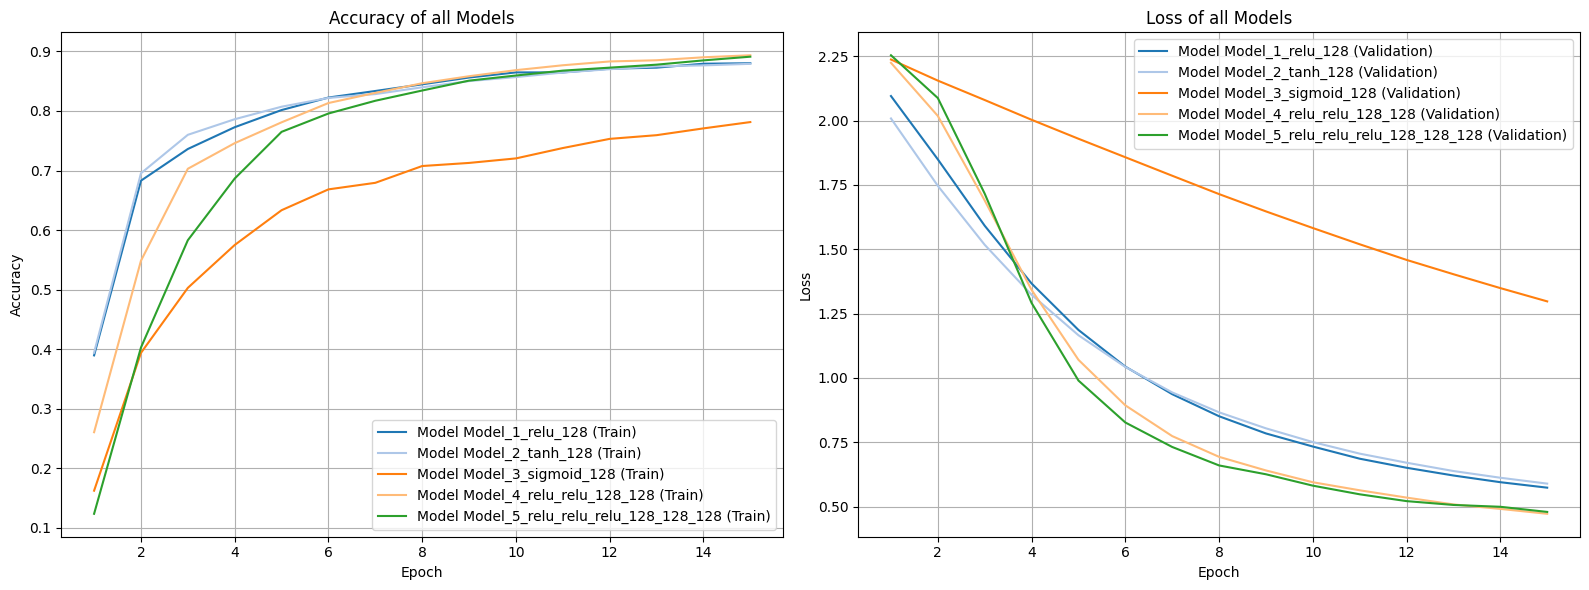

In [19]:
plot_accuracy_and_loss(all_train_accs, all_val_losses, num_epochs, model_names)

In [21]:
batch_size = 128
in_features = 28 * 28
out_features = 10
hidden_sizes_try = [
    [128, 128],
    [128, 128],
    [128, 128],
    [128, 128],
    [128, 128],
    [128, 128],
    [128, 128],
    [128, 128],
    [128, 128]
]

hidden_activations_try = [
    ["relu", "relu"],
    ["relu", "tanh"],
    ["relu", "sigmoid"],
    ["tanh", "relu"],
    ["tanh", "tanh"],
    ["tanh", "sigmoid"],
    ["sigmoid", "relu"],
    ["sigmoid", "tanh"],
    ["sigmoid", "sigmoid"]
]

dropout_rates = [
    [0.0, 0.0],
    [0.0, 0.0],
    [0.0, 0.0],
    [0.0, 0.0],
    [0.0, 0.0],
    [0.0, 0.0],
    [0.0, 0.0],
    [0.0, 0.0],
    [0.0, 0.0],
]

batch_norm = False

optimizer_name = "Adam"
learning_rate = 1e-5
num_epochs = 15
convergence_threshold = 1e-6
lambda_reg = 1e-8

tiny_train_dataset = Subset(train_dataset, range(5000))
tiny_val_dataset = Subset(validation_dataset, range(1250))

tiny_train = DataLoader(dataset=tiny_train_dataset, batch_size=batch_size, shuffle=True)
tiny_val = DataLoader(dataset=tiny_val_dataset, batch_size=int(batch_size/4), shuffle=False)


all_train_losses = []
all_val_losses = []
all_train_accs = []
all_val_accs = []
model_names = []


for i, (hidden_activations, hidden_sizes, dropout_rate) in enumerate(zip(hidden_activations_try, hidden_sizes_try, dropout_rates)):
      model_name = f"Model_{i+1}_{'_'.join(map(str, hidden_activations))}_{'_'.join(map(str, hidden_sizes))}"
      model_names.append(model_name)

      model1 = MLP(in_features, out_features, hidden_sizes, hidden_activations,
                   dropout_rate, batch_norm)

      print(f'model: {model_name}')
      train_losses, val_losses, train_accs, val_accs = model1.train_model(
                                                        train_data=tiny_train,
                                                        validation_data=tiny_val,
                                                        optimizer_name=optimizer_name,
                                                        lr=learning_rate,
                                                        num_epochs=num_epochs,
                                                        convergence_threshold=convergence_threshold,
                                                        lambda_reg=lambda_reg)

      all_train_losses.append(train_losses)
      all_val_losses.append(val_losses)
      all_train_accs.append(train_accs)
      all_val_accs.append(val_accs)


model: Model_1_relu_relu_128_128
Training Started
Epoch 1/15	 Training Loss: 2.3016, Training Acc: 0.0896, Validation Loss: 2.2994, Validation Acc: 0.1008, lr: 1e-05, reg: 1e-08
Epoch 2/15	 Training Loss: 2.2942, Training Acc: 0.1158, Validation Loss: 2.2914, Validation Acc: 0.1184, lr: 1e-05, reg: 1e-08
Epoch 3/15	 Training Loss: 2.2833, Training Acc: 0.1370, Validation Loss: 2.2830, Validation Acc: 0.1536, lr: 1e-05, reg: 1e-08
Epoch 4/15	 Training Loss: 2.2749, Training Acc: 0.1704, Validation Loss: 2.2739, Validation Acc: 0.1920, lr: 1e-05, reg: 1e-08
Epoch 5/15	 Training Loss: 2.2643, Training Acc: 0.2222, Validation Loss: 2.2637, Validation Acc: 0.2392, lr: 1e-05, reg: 1e-08
Epoch 6/15	 Training Loss: 2.2534, Training Acc: 0.2764, Validation Loss: 2.2524, Validation Acc: 0.2864, lr: 1e-05, reg: 1e-08
Epoch 7/15	 Training Loss: 2.2404, Training Acc: 0.3106, Validation Loss: 2.2398, Validation Acc: 0.3176, lr: 1e-05, reg: 1e-08
Epoch 8/15	 Training Loss: 2.2258, Training Acc: 0.339

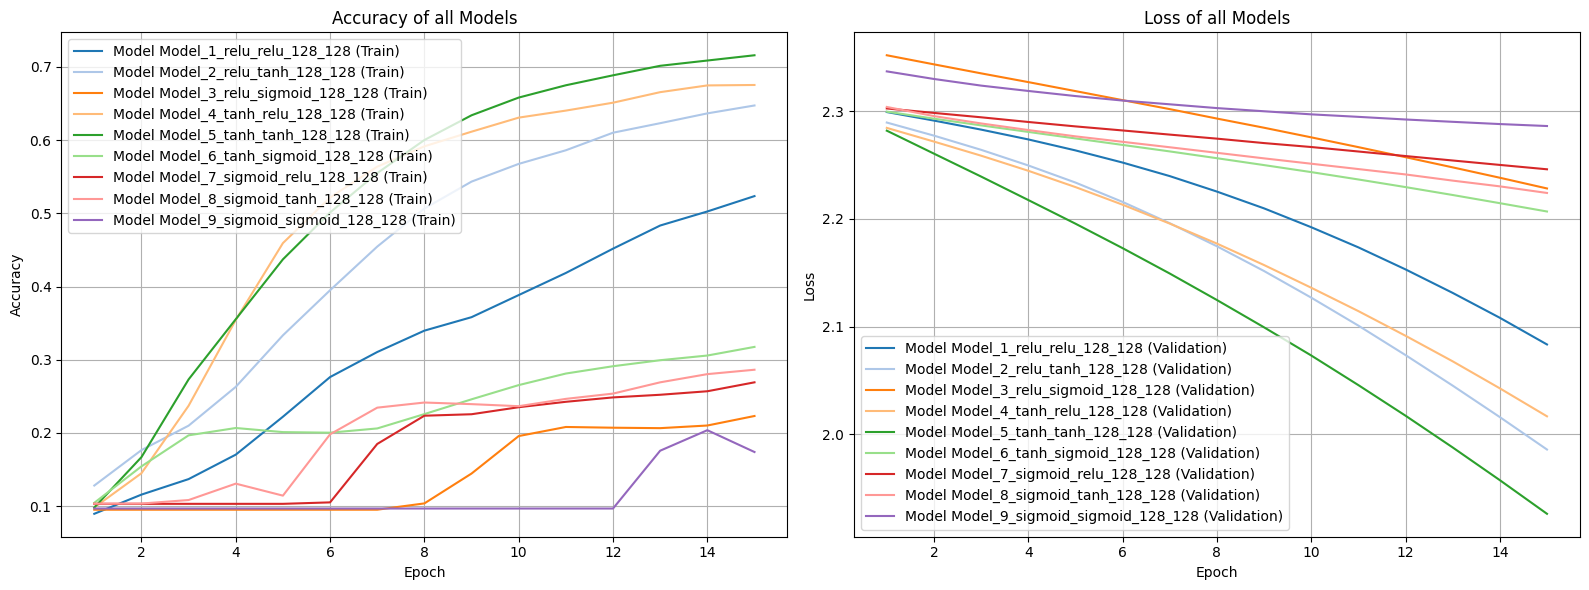

In [22]:
plot_accuracy_and_loss(all_train_accs, all_val_losses, num_epochs, model_names)

In [23]:
batch_size = 128
in_features = 28 * 28
out_features = 10
hidden_sizes_try = [
    [128, 128],
    [128, 128],
    [128, 128],
    [256, 128],
    [256, 128],
    [256, 128],
    [256, 256],
    [256, 256],
    [256, 256]
]

hidden_activations_try = [
    ["relu", "relu"],
    ["relu", "tanh"],
    ["tanh", "tanh"],
    ["relu", "relu"],
    ["relu", "tanh"],
    ["tanh", "tanh"],
    ["relu", "relu"],
    ["relu", "tanh"],
    ["tanh", "tanh"],
]

dropout_rates = [
    [0.0, 0.0],
    [0.0, 0.0],
    [0.0, 0.0],
    [0.0, 0.0],
    [0.0, 0.0],
    [0.0, 0.0],
    [0.0, 0.0],
    [0.0, 0.0],
    [0.0, 0.0],
]

batch_norm = False

optimizer_name = "Adam"
learning_rate = 1e-5
num_epochs = 15
convergence_threshold = 1e-6
lambda_reg = 1e-8

tiny_train_dataset = Subset(train_dataset, range(5000))
tiny_val_dataset = Subset(validation_dataset, range(1250))

tiny_train = DataLoader(dataset=tiny_train_dataset, batch_size=batch_size, shuffle=True)
tiny_val = DataLoader(dataset=tiny_val_dataset, batch_size=int(batch_size/4), shuffle=False)


all_train_losses = []
all_val_losses = []
all_train_accs = []
all_val_accs = []
model_names = []


for i, (hidden_activations, hidden_sizes, dropout_rate) in enumerate(zip(hidden_activations_try, hidden_sizes_try, dropout_rates)):
      model_name = f"Model_{i+1}_{'_'.join(map(str, hidden_activations))}_{'_'.join(map(str, hidden_sizes))}"
      model_names.append(model_name)

      model1 = MLP(in_features, out_features, hidden_sizes, hidden_activations,
                   dropout_rate, batch_norm)

      print(f'model: {model_name}')
      train_losses, val_losses, train_accs, val_accs = model1.train_model(
                                                        train_data=tiny_train,
                                                        validation_data=tiny_val,
                                                        optimizer_name=optimizer_name,
                                                        lr=learning_rate,
                                                        num_epochs=num_epochs,
                                                        convergence_threshold=convergence_threshold,
                                                        lambda_reg=lambda_reg)

      all_train_losses.append(train_losses)
      all_val_losses.append(val_losses)
      all_train_accs.append(train_accs)
      all_val_accs.append(val_accs)


model: Model_1_relu_relu_128_128
Training Started


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/15	 Training Loss: 2.2991, Training Acc: 0.1006, Validation Loss: 2.2917, Validation Acc: 0.1144, lr: 1e-05, reg: 1e-08
Epoch 2/15	 Training Loss: 2.2913, Training Acc: 0.1016, Validation Loss: 2.2834, Validation Acc: 0.1152, lr: 1e-05, reg: 1e-08
Epoch 3/15	 Training Loss: 2.2824, Training Acc: 0.1046, Validation Loss: 2.2747, Validation Acc: 0.1240, lr: 1e-05, reg: 1e-08
Epoch 4/15	 Training Loss: 2.2722, Training Acc: 0.1154, Validation Loss: 2.2651, Validation Acc: 0.1432, lr: 1e-05, reg: 1e-08
Epoch 5/15	 Training Loss: 2.2605, Training Acc: 0.1430, Validation Loss: 2.2544, Validation Acc: 0.1712, lr: 1e-05, reg: 1e-08
Epoch 6/15	 Training Loss: 2.2488, Training Acc: 0.1852, Validation Loss: 2.2425, Validation Acc: 0.2272, lr: 1e-05, reg: 1e-08
Epoch 7/15	 Training Loss: 2.2353, Training Acc: 0.2456, Validation Loss: 2.2290, Validation Acc: 0.2888, lr: 1e-05, reg: 1e-08
Epoch 8/15	 Training Loss: 2.2208, Training Acc: 0.3062, Validation Loss: 2.2142, Validation Acc: 0.3400

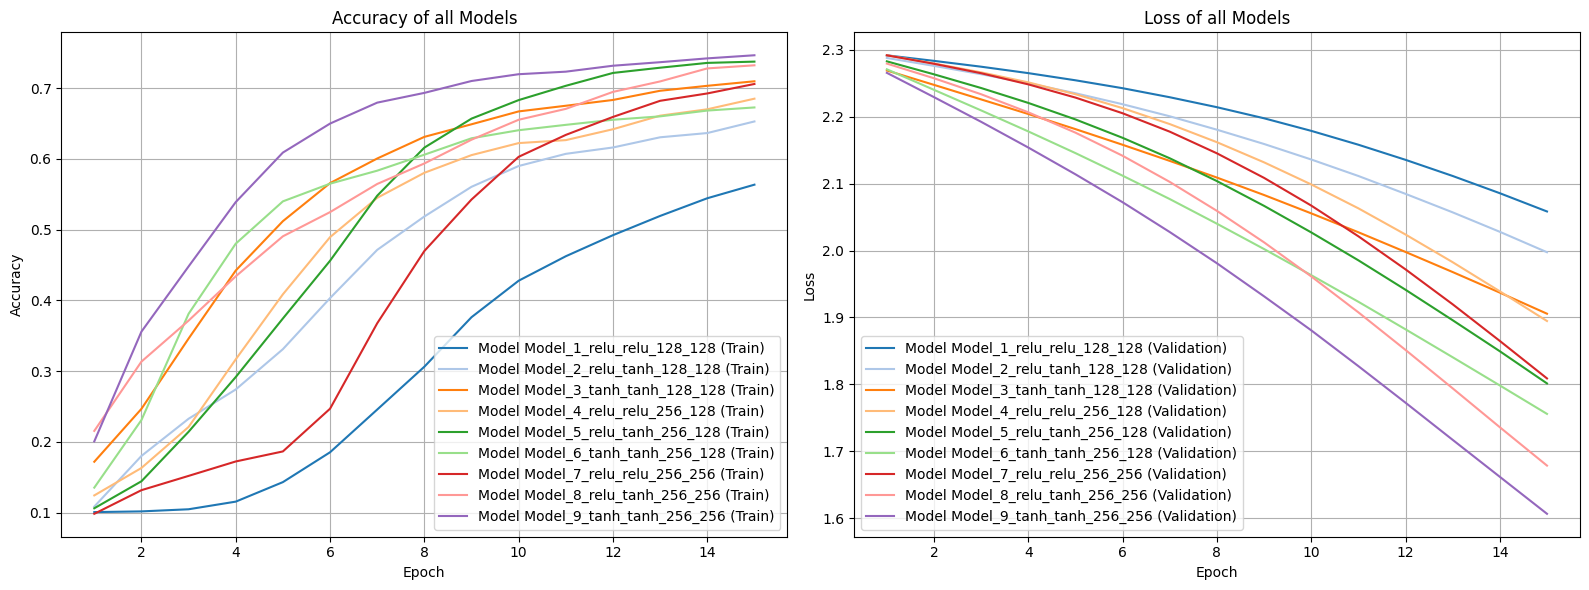

In [24]:
plot_accuracy_and_loss(all_train_accs, all_val_losses, num_epochs, model_names)

In [25]:
batch_size = 128
in_features = 28 * 28
out_features = 10
hidden_sizes_try = [
    [256, 256],
    [256, 256],
    [512, 256],
    [512, 256],
    [512, 512],
    [512, 512]
]

hidden_activations_try = [
    ["relu", "tanh"],
    ["tanh", "tanh"],
    ["relu", "tanh"],
    ["tanh", "tanh"],
    ["relu", "tanh"],
    ["tanh", "tanh"],
]

dropout_rates = [
    [0.0, 0.0],
    [0.0, 0.0],
    [0.0, 0.0],
    [0.0, 0.0],
    [0.0, 0.0],
    [0.0, 0.0]
]

batch_norm = False

optimizer_name = "Adam"
learning_rate = 1e-5
num_epochs = 15
convergence_threshold = 1e-6
lambda_reg = 1e-8

tiny_train_dataset = Subset(train_dataset, range(5000))
tiny_val_dataset = Subset(validation_dataset, range(1250))

tiny_train = DataLoader(dataset=tiny_train_dataset, batch_size=batch_size, shuffle=True)
tiny_val = DataLoader(dataset=tiny_val_dataset, batch_size=int(batch_size/4), shuffle=False)


all_train_losses = []
all_val_losses = []
all_train_accs = []
all_val_accs = []
model_names = []


for i, (hidden_activations, hidden_sizes, dropout_rate) in enumerate(zip(hidden_activations_try, hidden_sizes_try, dropout_rates)):
      model_name = f"Model_{i+1}_{'_'.join(map(str, hidden_activations))}_{'_'.join(map(str, hidden_sizes))}"
      model_names.append(model_name)

      model1 = MLP(in_features, out_features, hidden_sizes, hidden_activations,
                   dropout_rate, batch_norm)

      print(f'model: {model_name}')
      train_losses, val_losses, train_accs, val_accs = model1.train_model(
                                                        train_data=tiny_train,
                                                        validation_data=tiny_val,
                                                        optimizer_name=optimizer_name,
                                                        lr=learning_rate,
                                                        num_epochs=num_epochs,
                                                        convergence_threshold=convergence_threshold,
                                                        lambda_reg=lambda_reg)

      all_train_losses.append(train_losses)
      all_val_losses.append(val_losses)
      all_train_accs.append(train_accs)
      all_val_accs.append(val_accs)


model: Model_1_relu_tanh_256_256
Training Started


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/15	 Training Loss: 2.2919, Training Acc: 0.1450, Validation Loss: 2.2802, Validation Acc: 0.1840, lr: 1e-05, reg: 1e-08
Epoch 2/15	 Training Loss: 2.2682, Training Acc: 0.2594, Validation Loss: 2.2582, Validation Acc: 0.2920, lr: 1e-05, reg: 1e-08
Epoch 3/15	 Training Loss: 2.2427, Training Acc: 0.3698, Validation Loss: 2.2340, Validation Acc: 0.3856, lr: 1e-05, reg: 1e-08
Epoch 4/15	 Training Loss: 2.2166, Training Acc: 0.4784, Validation Loss: 2.2066, Validation Acc: 0.4936, lr: 1e-05, reg: 1e-08
Epoch 5/15	 Training Loss: 2.1847, Training Acc: 0.5606, Validation Loss: 2.1757, Validation Acc: 0.5664, lr: 1e-05, reg: 1e-08
Epoch 6/15	 Training Loss: 2.1515, Training Acc: 0.6204, Validation Loss: 2.1413, Validation Acc: 0.6152, lr: 1e-05, reg: 1e-08
Epoch 7/15	 Training Loss: 2.1107, Training Acc: 0.6682, Validation Loss: 2.1029, Validation Acc: 0.6472, lr: 1e-05, reg: 1e-08
Epoch 8/15	 Training Loss: 2.0694, Training Acc: 0.6942, Validation Loss: 2.0604, Validation Acc: 0.6640

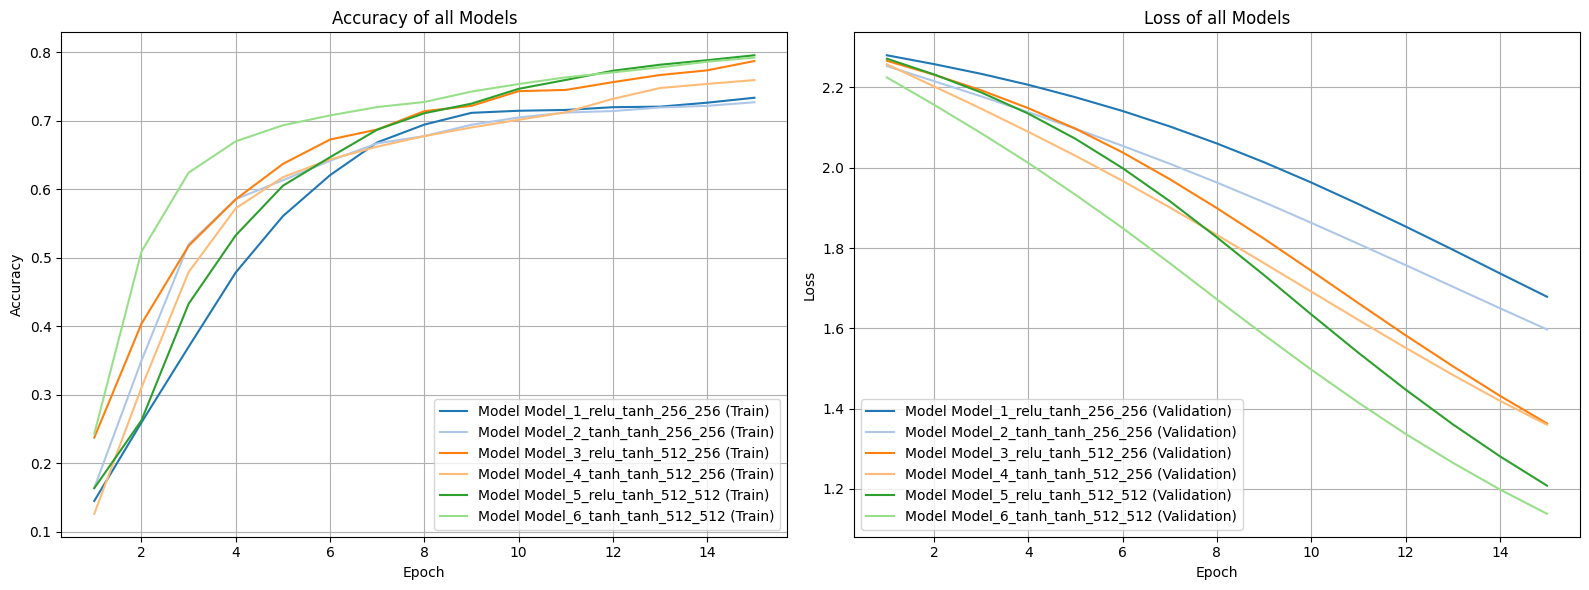

In [26]:
plot_accuracy_and_loss(all_train_accs, all_val_losses, num_epochs, model_names)

In [32]:
batch_size = 128
in_features = 28 * 28
out_features = 10
hidden_sizes = [512, 512]
hidden_activations = ["relu", "tanh"]

optimizer_name = "Adam"
learning_rate_try = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
num_epochs = 10
convergence_threshold = 1e-6
lambda_reg = 1e-8

tiny_train_dataset = Subset(train_dataset, range(10000))
tiny_val_dataset = Subset(validation_dataset, range(2500))

tiny_train = DataLoader(dataset=tiny_train_dataset, batch_size=batch_size, shuffle=True)
tiny_val = DataLoader(dataset=tiny_val_dataset, batch_size=int(batch_size/4), shuffle=False)


all_train_losses = []
all_val_losses = []
all_train_accs = []
all_val_accs = []
model_names = []

for i, learning_rate in enumerate(learning_rate_try):
    model_name = f"Model_{i}_lr_{(learning_rate)}"
    model_names.append(model_name)

    model1 = MLP(in_features, out_features, hidden_sizes, hidden_activations)

    train_losses, val_losses, train_accs, val_accs = model1.train_model(
                                                    train_data=tiny_train,
                                                    validation_data=tiny_val,
                                                    optimizer_name=optimizer_name,
                                                    lr=learning_rate,
                                                    num_epochs=num_epochs,
                                                    convergence_threshold=convergence_threshold,
                                                    lambda_reg=lambda_reg)
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    all_train_accs.append(train_accs)
    all_val_accs.append(val_accs)

Training Started
Epoch 1/10	 Training Loss: 44.8498, Training Acc: 0.1041, Validation Loss: 22.4077, Validation Acc: 0.1188, lr: 0.1, reg: 1e-08
Epoch 2/10	 Training Loss: 21.7272, Training Acc: 0.1150, Validation Loss: 30.5781, Validation Acc: 0.0936, lr: 0.1, reg: 1e-08
Epoch 3/10	 Training Loss: 21.3401, Training Acc: 0.1047, Validation Loss: 22.6794, Validation Acc: 0.0972, lr: 0.1, reg: 1e-08
Epoch 4/10	 Training Loss: 26.3295, Training Acc: 0.1050, Validation Loss: 29.8647, Validation Acc: 0.1204, lr: 0.1, reg: 1e-08
Epoch 5/10	 Training Loss: 19.6654, Training Acc: 0.1148, Validation Loss: 31.0015, Validation Acc: 0.1044, lr: 0.1, reg: 1e-08
Epoch 6/10	 Training Loss: 19.7518, Training Acc: 0.1164, Validation Loss: 16.1941, Validation Acc: 0.0964, lr: 0.1, reg: 1e-08
Epoch 7/10	 Training Loss: 15.8044, Training Acc: 0.1434, Validation Loss: 16.6327, Validation Acc: 0.2088, lr: 0.1, reg: 1e-08
Epoch 8/10	 Training Loss: 20.2475, Training Acc: 0.1687, Validation Loss: 17.4107, Val

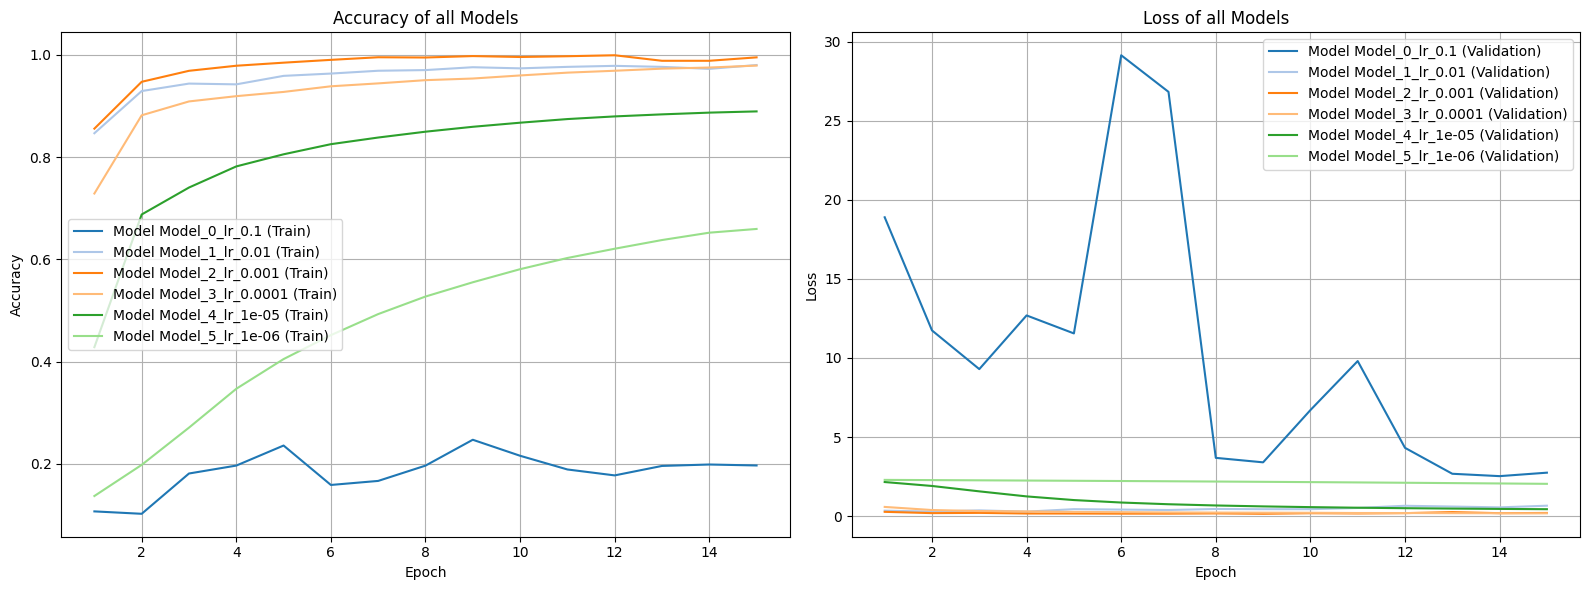

In [29]:
plot_accuracy_and_loss(all_train_accs, all_val_losses, num_epochs, model_names)

In [33]:
batch_size = 128
in_features = 28 * 28
out_features = 10
hidden_sizes = [512, 512]
hidden_activations = ["relu", "tanh"]

optimizer_name = "Adam"
learning_rate_try = [1e-3, 1e-4, 1e-5]
num_epochs = 10
convergence_threshold = 1e-6
lambda_reg_try = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]

tiny_train_dataset = Subset(train_dataset, range(5000))
tiny_val_dataset = Subset(validation_dataset, range(1250))

tiny_train = DataLoader(dataset=tiny_train_dataset, batch_size=batch_size, shuffle=True)
tiny_val = DataLoader(dataset=tiny_val_dataset, batch_size=int(batch_size/4), shuffle=False)


all_train_losses = []
all_val_losses = []
all_train_accs = []
all_val_accs = []
model_names = []


for i in range(len(learning_rate_try)):
  for j in range(len(lambda_reg_try)):
      model_index = i * len(learning_rate_try) + j + 1
      learning_rate = learning_rate_try[i]
      lambda_reg = lambda_reg_try[j]
      model_name = f"Model_{model_index}_lr_{(learning_rate)}_reg{(lambda_reg)}"
      model_names.append(model_name)

      model1 = MLP(in_features, out_features, hidden_sizes, hidden_activations)

      train_losses, val_losses, train_accs, val_accs = model1.train_model(
                                                    train_data=tiny_train,
                                                    validation_data=tiny_val,
                                                    optimizer_name=optimizer_name,
                                                    lr=learning_rate,
                                                    num_epochs=num_epochs,
                                                    convergence_threshold=convergence_threshold,
                                                    lambda_reg=lambda_reg)
      all_train_losses.append(train_losses)
      all_val_losses.append(val_losses)
      all_train_accs.append(train_accs)
      all_val_accs.append(val_accs)

Training Started


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/10	 Training Loss: 11.9058, Training Acc: 0.2578, Validation Loss: 2.2982, Validation Acc: 0.1808, lr: 0.001, reg: 0.1
Epoch 2/10	 Training Loss: 2.3882, Training Acc: 0.1250, Validation Loss: 2.3021, Validation Acc: 0.1160, lr: 0.001, reg: 0.1
Epoch 3/10	 Training Loss: 2.3036, Training Acc: 0.1222, Validation Loss: 2.3015, Validation Acc: 0.1160, lr: 0.001, reg: 0.1
Epoch 4/10	 Training Loss: 2.3013, Training Acc: 0.1222, Validation Loss: 2.3013, Validation Acc: 0.1160, lr: 0.001, reg: 0.1
Epoch 5/10	 Training Loss: 2.3018, Training Acc: 0.1222, Validation Loss: 2.3013, Validation Acc: 0.1160, lr: 0.001, reg: 0.1
Epoch 6/10	 Training Loss: 2.3012, Training Acc: 0.1222, Validation Loss: 2.3012, Validation Acc: 0.1160, lr: 0.001, reg: 0.1
Epoch 7/10	 Training Loss: 2.3012, Training Acc: 0.1222, Validation Loss: 2.3011, Validation Acc: 0.1160, lr: 0.001, reg: 0.1
Epoch 8/10	 Training Loss: 2.3014, Training Acc: 0.1222, Validation Loss: 2.3010, Validation Acc: 0.1160, lr: 0.0005,

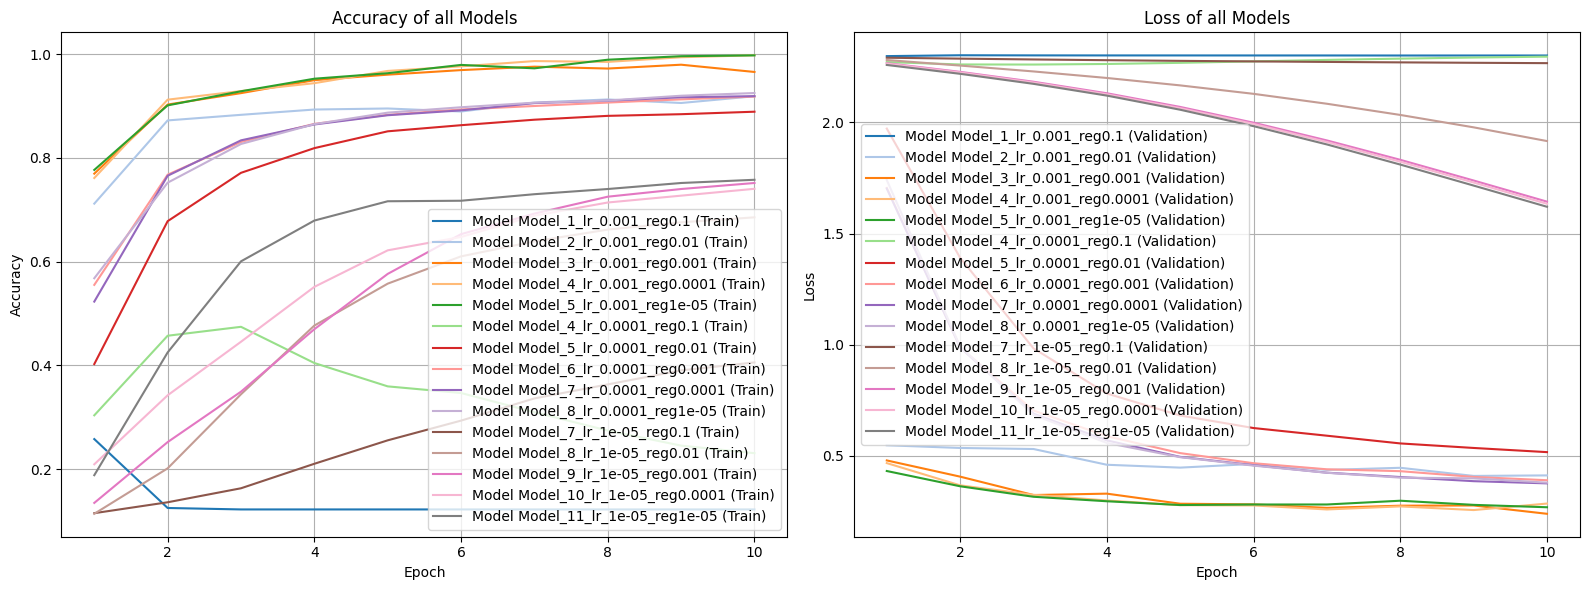

In [34]:
plot_accuracy_and_loss(all_train_accs, all_val_losses, num_epochs, model_names)

In [36]:
batch_size = 128
in_features = 28 * 28
out_features = 10
hidden_sizes = [512, 512]
hidden_activations = ["relu", "tanh"]

optimizer_name_try = ["Adam", "SGD", "RMSprop"]
learning_rate_try = [1e-5, 1e-4, 1e-4]
num_epochs = 10
convergence_threshold = 1e-6
lambda_reg_try = [1e-4, 1e-4, 1e-5]

tiny_train_dataset = Subset(train_dataset, range(5000))
tiny_val_dataset = Subset(validation_dataset, range(1250))

tiny_train = DataLoader(dataset=tiny_train_dataset, batch_size=batch_size, shuffle=True)
tiny_val = DataLoader(dataset=tiny_val_dataset, batch_size=int(batch_size/4), shuffle=False)


all_train_losses = []
all_val_losses = []
all_train_accs = []
all_val_accs = []
model_names = []


for i, optimizer_name in enumerate(optimizer_name_try):
  for j, (learning_rate, lambda_reg) in enumerate(zip(learning_rate_try, lambda_reg_try)):
      model_index = i * len(learning_rate_try) + j + 1
      model_name = f"Model_{model_index}_{'_'.join(map(str, optimizer_name))}_lr{learning_rate}_reg{lambda_reg}"
      model_names.append(model_name)

      model1 = MLP(in_features, out_features, hidden_sizes, hidden_activations)

      train_losses, val_losses, train_accs, val_accs = model1.train_model(
                                                    train_data=tiny_train,
                                                    validation_data=tiny_val,
                                                    optimizer_name=optimizer_name,
                                                    lr=learning_rate,
                                                    num_epochs=num_epochs,
                                                    convergence_threshold=convergence_threshold,
                                                    lambda_reg=lambda_reg)
      all_train_losses.append(train_losses)
      all_val_losses.append(val_losses)
      all_train_accs.append(train_accs)
      all_val_accs.append(val_accs)

Training Started


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/10	 Training Loss: 2.3211, Training Acc: 0.1706, Validation Loss: 2.2695, Validation Acc: 0.3080, lr: 1e-05, reg: 0.0001
Epoch 2/10	 Training Loss: 2.2784, Training Acc: 0.4668, Validation Loss: 2.2291, Validation Acc: 0.5104, lr: 1e-05, reg: 0.0001
Epoch 3/10	 Training Loss: 2.2331, Training Acc: 0.6024, Validation Loss: 2.1843, Validation Acc: 0.5840, lr: 1e-05, reg: 0.0001
Epoch 4/10	 Training Loss: 2.1795, Training Acc: 0.6618, Validation Loss: 2.1320, Validation Acc: 0.6200, lr: 1e-05, reg: 0.0001
Epoch 5/10	 Training Loss: 2.1218, Training Acc: 0.6622, Validation Loss: 2.0708, Validation Acc: 0.6360, lr: 1e-05, reg: 0.0001
Epoch 6/10	 Training Loss: 2.0516, Training Acc: 0.6968, Validation Loss: 2.0000, Validation Acc: 0.6568, lr: 1e-05, reg: 0.0001
Epoch 7/10	 Training Loss: 1.9712, Training Acc: 0.6984, Validation Loss: 1.9197, Validation Acc: 0.6656, lr: 1e-05, reg: 0.0001
Epoch 8/10	 Training Loss: 1.8810, Training Acc: 0.7082, Validation Loss: 1.8305, Validation Acc:

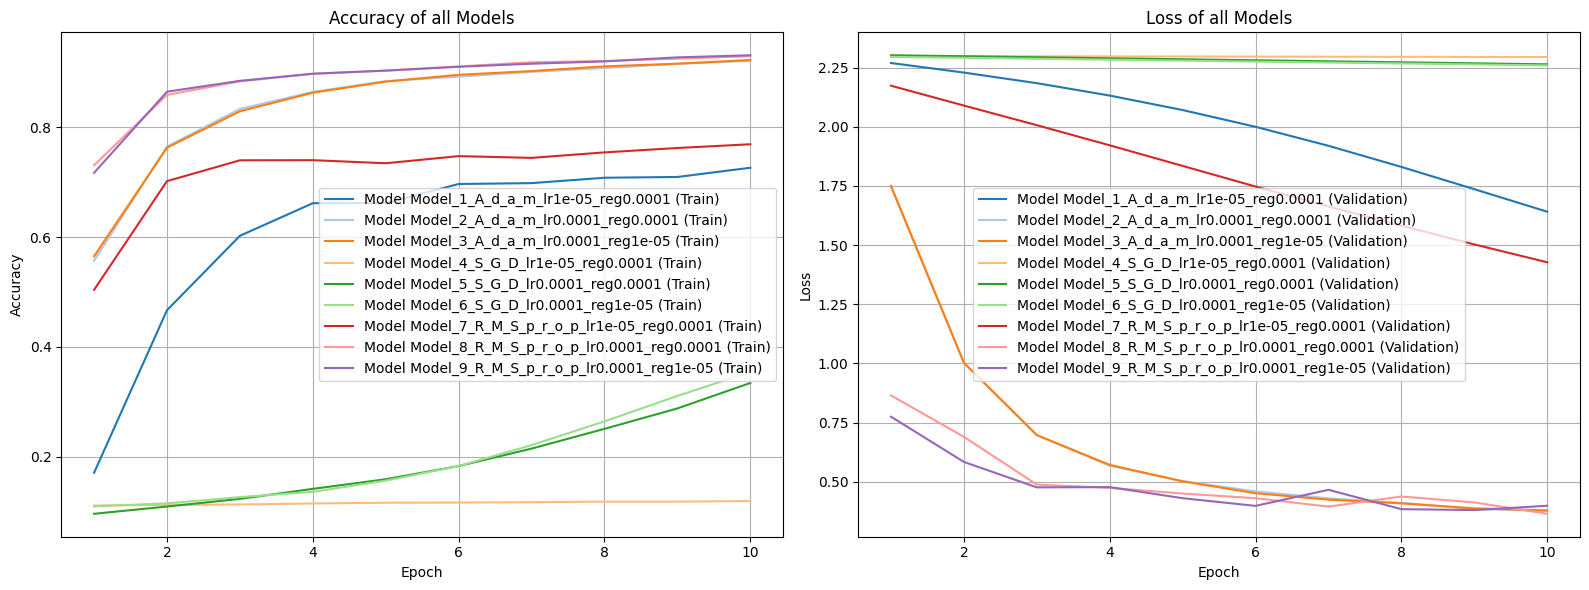

In [37]:
plot_accuracy_and_loss(all_train_accs, all_val_losses, num_epochs, model_names)

In [38]:
batch_size = 128
in_features = 28 * 28
out_features = 10
hidden_sizes = [512, 512]
hidden_activations = ["relu", "tanh"]

optimizer_name_try = ["Adam", "RMSprop"]
learning_rate_try = [1e-6, 1e-6, 1e-5, 1e-4, 1e-4]
num_epochs = 10
convergence_threshold = 1e-6
lambda_reg_try = [1e-5, 1e-4, 1e-4, 1e-4, 1e-5]

tiny_train_dataset = Subset(train_dataset, range(5000))
tiny_val_dataset = Subset(validation_dataset, range(1250))

tiny_train = DataLoader(dataset=tiny_train_dataset, batch_size=batch_size, shuffle=True)
tiny_val = DataLoader(dataset=tiny_val_dataset, batch_size=int(batch_size/4), shuffle=False)


all_train_losses = []
all_val_losses = []
all_train_accs = []
all_val_accs = []
model_names = []


for i, optimizer_name in enumerate(optimizer_name_try):
  for j, (learning_rate, lambda_reg) in enumerate(zip(learning_rate_try, lambda_reg_try)):
      model_index = i * len(learning_rate_try) + j + 1
      model_name = f"Model_{model_index}_{'_'.join(map(str, optimizer_name))}_lr{learning_rate}_reg{lambda_reg}"
      model_names.append(model_name)

      model1 = MLP(in_features, out_features, hidden_sizes, hidden_activations)

      train_losses, val_losses, train_accs, val_accs = model1.train_model(
                                                    train_data=tiny_train,
                                                    validation_data=tiny_val,
                                                    optimizer_name=optimizer_name,
                                                    lr=learning_rate,
                                                    num_epochs=num_epochs,
                                                    convergence_threshold=convergence_threshold,
                                                    lambda_reg=lambda_reg)
      all_train_losses.append(train_losses)
      all_val_losses.append(val_losses)
      all_train_accs.append(train_accs)
      all_val_accs.append(val_accs)

Training Started


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/10	 Training Loss: 2.3001, Training Acc: 0.1942, Validation Loss: 2.2951, Validation Acc: 0.1992, lr: 1e-06, reg: 1e-05
Epoch 2/10	 Training Loss: 2.2955, Training Acc: 0.2196, Validation Loss: 2.2913, Validation Acc: 0.2184, lr: 1e-06, reg: 1e-05
Epoch 3/10	 Training Loss: 2.2914, Training Acc: 0.2482, Validation Loss: 2.2874, Validation Acc: 0.2520, lr: 1e-06, reg: 1e-05
Epoch 4/10	 Training Loss: 2.2872, Training Acc: 0.2772, Validation Loss: 2.2836, Validation Acc: 0.2816, lr: 1e-06, reg: 1e-05
Epoch 5/10	 Training Loss: 2.2837, Training Acc: 0.3046, Validation Loss: 2.2798, Validation Acc: 0.3064, lr: 1e-06, reg: 1e-05
Epoch 6/10	 Training Loss: 2.2794, Training Acc: 0.3324, Validation Loss: 2.2759, Validation Acc: 0.3280, lr: 1e-06, reg: 1e-05
Epoch 7/10	 Training Loss: 2.2756, Training Acc: 0.3556, Validation Loss: 2.2721, Validation Acc: 0.3504, lr: 1e-06, reg: 1e-05
Epoch 8/10	 Training Loss: 2.2720, Training Acc: 0.3806, Validation Loss: 2.2682, Validation Acc: 0.3704

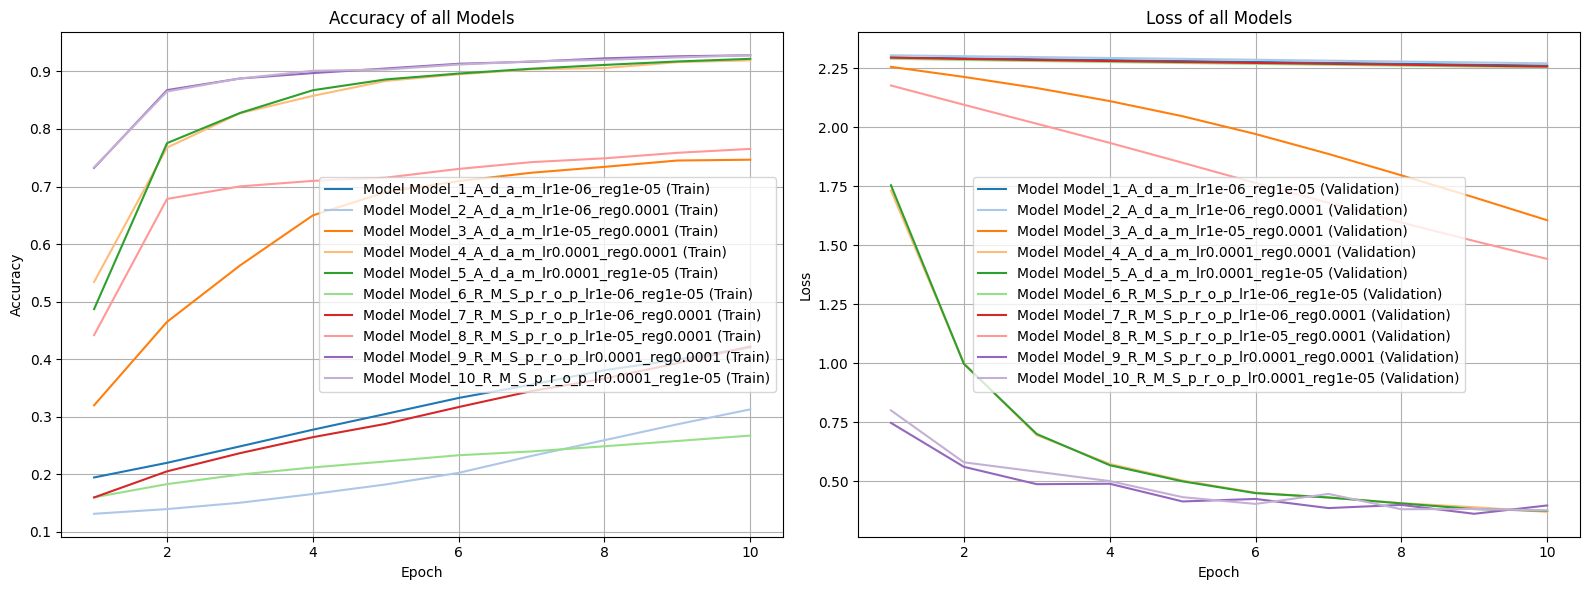

In [39]:
plot_accuracy_and_loss(all_train_accs, all_val_losses, num_epochs, model_names)

In [48]:
batch_size_try = [4, 16 ,32, 64, 128, 256, 512, 1024]
in_features = 28 * 28
out_features = 10
hidden_sizes = [512, 512]
hidden_activations = ["relu", "tanh"]

optimizer_name = "Adam"
learning_rate_try = 1e-4
num_epochs = 5
convergence_threshold = 1e-6
lambda_reg_try = 1e-5

tiny_train_dataset = Subset(train_dataset, range(10000))
tiny_val_dataset = Subset(validation_dataset, range(2500))


all_train_losses = []
all_val_losses = []
all_train_accs = []
all_val_accs = []
model_names = []



for i, batch_size in enumerate(batch_size_try):

    tiny_train = DataLoader(dataset=tiny_train_dataset, batch_size=batch_size, shuffle=True)
    tiny_val = DataLoader(dataset=tiny_val_dataset, batch_size=int(batch_size/4), shuffle=False)

    train_data, test_data, validation_data = load_data(batch_size)

    model1 = MLP(in_features, out_features, hidden_sizes, hidden_activations)

    start_time = time.time()

    train_losses, val_losses, train_accs, val_accs = model1.train_model(
                                                  train_data=tiny_train,
                                                  validation_data=tiny_val,
                                                  optimizer_name=optimizer_name,
                                                  lr=learning_rate,
                                                  num_epochs=num_epochs,
                                                  convergence_threshold=convergence_threshold,
                                                  lambda_reg=lambda_reg)

    training_time = time.time() - start_time

    model_name = f"Model_{i}_batch_{(batch_size)}_time{training_time:.4f}"
    model_names.append(model_name)
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    all_train_accs.append(train_accs)
    all_val_accs.append(val_accs)

Training Started
Epoch 1/5	 Training Loss: 0.5464, Training Acc: 0.8496, Validation Loss: 0.2852, Validation Acc: 0.9188, lr: 0.0001, reg: 1e-05
Epoch 2/5	 Training Loss: 0.2431, Training Acc: 0.9316, Validation Loss: 0.2139, Validation Acc: 0.9376, lr: 0.0001, reg: 1e-05
Epoch 3/5	 Training Loss: 0.1631, Training Acc: 0.9546, Validation Loss: 0.1877, Validation Acc: 0.9428, lr: 0.0001, reg: 1e-05
Epoch 4/5	 Training Loss: 0.1168, Training Acc: 0.9675, Validation Loss: 0.1625, Validation Acc: 0.9520, lr: 0.0001, reg: 1e-05
Epoch 5/5	 Training Loss: 0.0851, Training Acc: 0.9762, Validation Loss: 0.1659, Validation Acc: 0.9496, lr: 0.0001, reg: 1e-05
Training finished
Training Started
Epoch 1/5	 Training Loss: 0.7604, Training Acc: 0.8130, Validation Loss: 0.3605, Validation Acc: 0.8944, lr: 0.0001, reg: 1e-05
Epoch 2/5	 Training Loss: 0.3080, Training Acc: 0.9114, Validation Loss: 0.2772, Validation Acc: 0.9188, lr: 0.0001, reg: 1e-05
Epoch 3/5	 Training Loss: 0.2371, Training Acc: 0.93

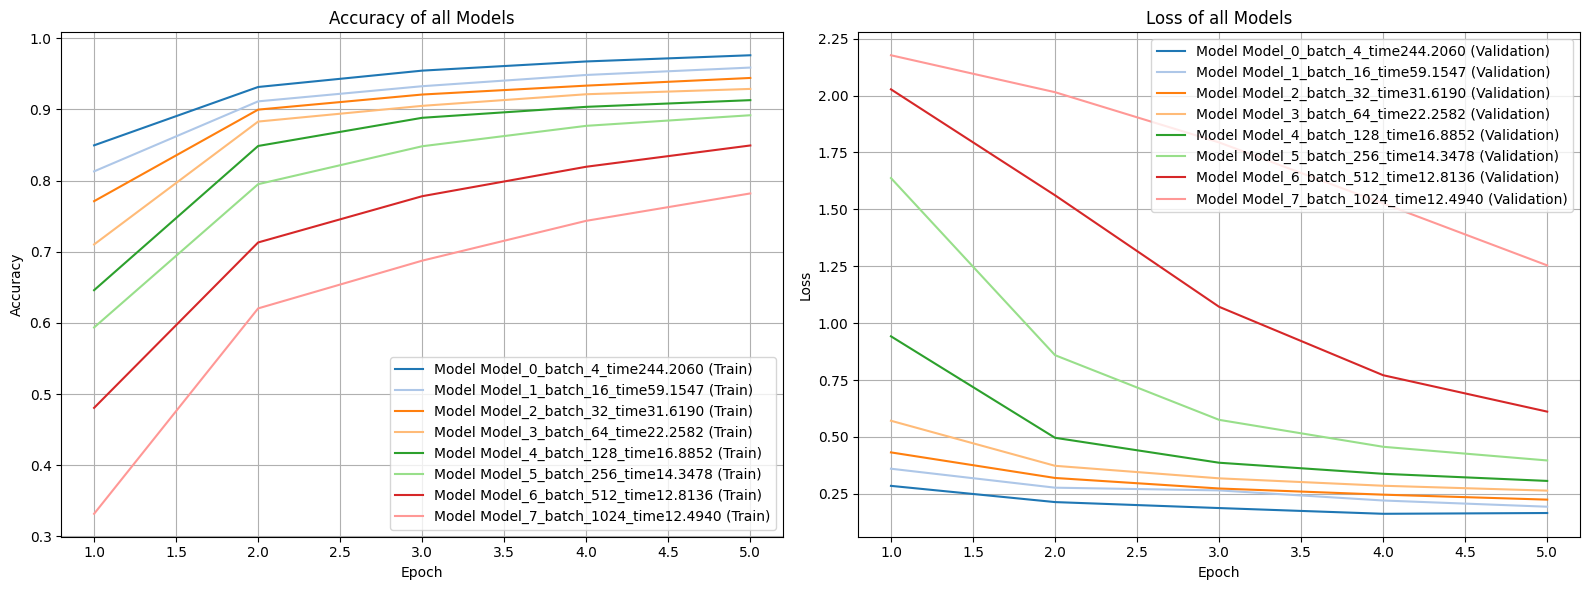

In [49]:
plot_accuracy_and_loss(all_train_accs, all_val_losses, num_epochs, model_names)

In [57]:
# Batch Normalize

batch_size = 128
in_features = 28 * 28
out_features = 10
hidden_sizes = [512, 512]
hidden_activations = ["relu", "tanh"]
dropout_rates = [0.0, 0.0]
batch_norm_try = [True, False]

optimizer_name = "Adam"
learning_rate = 1e-4
num_epochs = 10
convergence_threshold = 1e-6
lambda_reg = 1e-5


tiny_train_dataset = Subset(train_dataset, range(1000))
tiny_val_dataset = Subset(validation_dataset, range(250))

tiny_train = DataLoader(dataset=tiny_train_dataset, batch_size=batch_size, shuffle=True)
tiny_val = DataLoader(dataset=tiny_val_dataset, batch_size=int(batch_size/4), shuffle=False)


all_train_losses = []
all_val_losses = []
all_train_accs = []
all_val_accs = []
model_names = []


for batch_norm in batch_norm_try:
      model_name = f'bn_{batch_norm}'
      model_names.append(model_name)

      model1 = MLP(in_features, out_features, hidden_sizes, hidden_activations, dropout_rates, batch_norm)
      train_losses, val_losses, train_accs, val_accs = model1.train_model(
                  tiny_train, tiny_val, optimizer_name, learning_rate, num_epochs, convergence_threshold, lambda_reg)

      all_train_losses.append(train_losses)
      all_val_losses.append(val_losses)
      all_train_accs.append(train_accs)
      all_val_accs.append(val_accs)

Training Started
Epoch 1/10	 Training Loss: 1.8932, Training Acc: 0.4720, Validation Loss: 2.1157, Validation Acc: 0.5520, lr: 0.0001, reg: 1e-05
Epoch 2/10	 Training Loss: 1.2439, Training Acc: 0.7490, Validation Loss: 1.7366, Validation Acc: 0.7520, lr: 0.0001, reg: 1e-05
Epoch 3/10	 Training Loss: 0.9034, Training Acc: 0.8300, Validation Loss: 1.2530, Validation Acc: 0.8280, lr: 0.0001, reg: 1e-05
Epoch 4/10	 Training Loss: 0.7036, Training Acc: 0.8670, Validation Loss: 0.8734, Validation Acc: 0.8440, lr: 0.0001, reg: 1e-05
Epoch 5/10	 Training Loss: 0.5818, Training Acc: 0.8840, Validation Loss: 0.6604, Validation Acc: 0.8440, lr: 0.0001, reg: 1e-05
Epoch 6/10	 Training Loss: 0.4857, Training Acc: 0.9080, Validation Loss: 0.5492, Validation Acc: 0.8600, lr: 0.0001, reg: 1e-05
Epoch 7/10	 Training Loss: 0.4169, Training Acc: 0.9200, Validation Loss: 0.4878, Validation Acc: 0.8680, lr: 0.0001, reg: 1e-05
Epoch 8/10	 Training Loss: 0.3704, Training Acc: 0.9320, Validation Loss: 0.4494

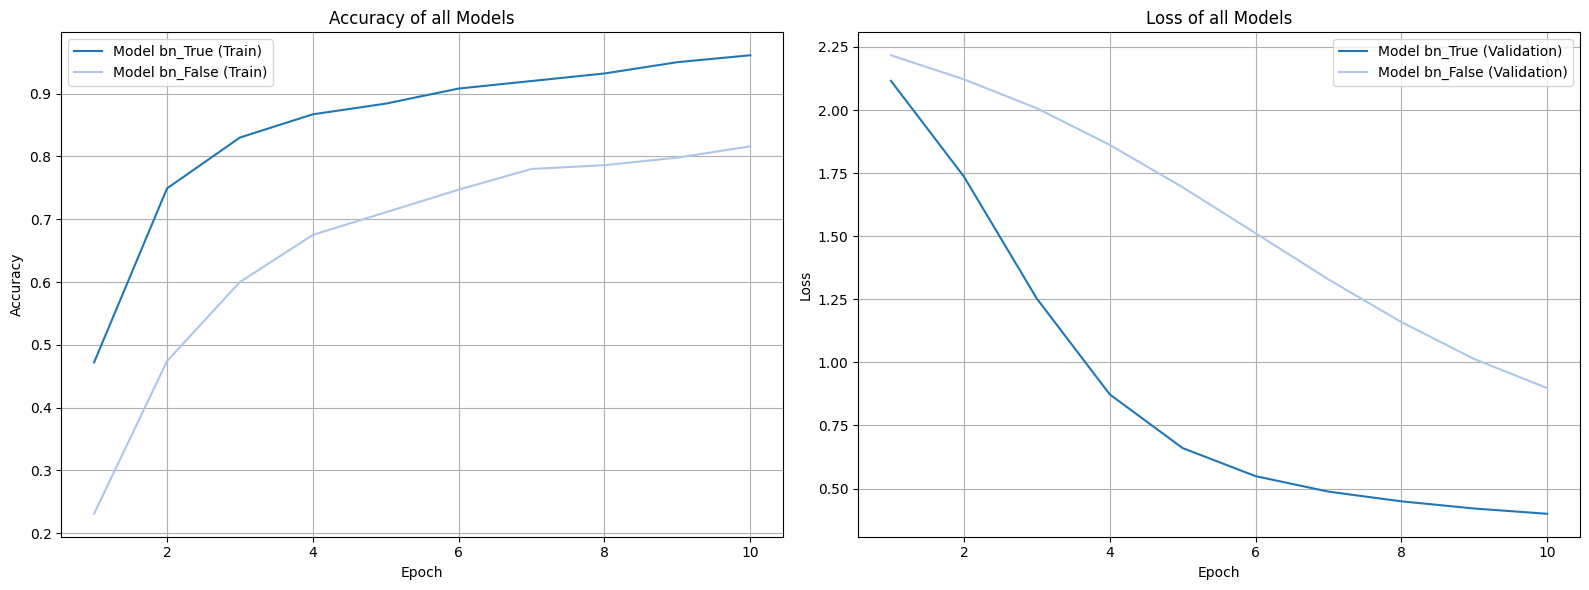

In [58]:
plot_accuracy_and_loss(all_train_accs, all_val_losses, num_epochs, model_names)

In [75]:
# Drop-out

batch_size = 256
in_features = 28 * 28
out_features = 10
hidden_sizes = [512, 512]
hidden_activations = ["relu", "tanh"]
dropout_rates_try = [
    [0.0, 0.0],
    [0.1, 0.1],
    [0.2, 0.2],
    [0.3, 0.3],
    [0.4, 0.4],
    [0.5, 0.5]
    ]
batch_norm_try = True

optimizer_name = "Adam"
learning_rate = 1e-4
num_epochs = 10
convergence_threshold = 1e-6
lambda_reg = 1e-5


tiny_train_dataset = Subset(train_dataset, range(5000))
tiny_val_dataset = Subset(validation_dataset, range(1250))

tiny_train = DataLoader(dataset=tiny_train_dataset, batch_size=batch_size, shuffle=True)
tiny_val = DataLoader(dataset=tiny_val_dataset, batch_size=int(batch_size/4), shuffle=False)


all_train_losses = []
all_val_losses = []
all_train_accs = []
all_val_accs = []
model_names = []


for dropout_rates in dropout_rates_try:
      model_name = f'dr_{dropout_rates}'
      model_names.append(model_name)

      model1 = MLP(in_features, out_features, hidden_sizes, hidden_activations, dropout_rates, batch_norm)
      train_losses, val_losses, train_accs, val_accs = model1.train_model(
                  tiny_train, tiny_val, optimizer_name, learning_rate, num_epochs, convergence_threshold, lambda_reg)

      all_train_losses.append(train_losses)
      all_val_losses.append(val_losses)
      all_train_accs.append(train_accs)
      all_val_accs.append(val_accs)

Training Started
Epoch 1/10	 Training Loss: 2.1783, Training Acc: 0.4374, Validation Loss: 2.0287, Validation Acc: 0.6432, lr: 0.0001, reg: 1e-05
Epoch 2/10	 Training Loss: 1.8184, Training Acc: 0.7158, Validation Loss: 1.5963, Validation Acc: 0.7024, lr: 0.0001, reg: 1e-05
Epoch 3/10	 Training Loss: 1.3394, Training Acc: 0.7604, Validation Loss: 1.1279, Validation Acc: 0.7744, lr: 0.0001, reg: 1e-05
Epoch 4/10	 Training Loss: 0.9442, Training Acc: 0.8118, Validation Loss: 0.8253, Validation Acc: 0.8104, lr: 0.0001, reg: 1e-05
Epoch 5/10	 Training Loss: 0.7128, Training Acc: 0.8426, Validation Loss: 0.6599, Validation Acc: 0.8416, lr: 0.0001, reg: 1e-05
Epoch 6/10	 Training Loss: 0.5835, Training Acc: 0.8658, Validation Loss: 0.5583, Validation Acc: 0.8608, lr: 0.0001, reg: 1e-05
Epoch 7/10	 Training Loss: 0.5056, Training Acc: 0.8826, Validation Loss: 0.4974, Validation Acc: 0.8680, lr: 0.0001, reg: 1e-05
Epoch 8/10	 Training Loss: 0.4515, Training Acc: 0.8880, Validation Loss: 0.4477

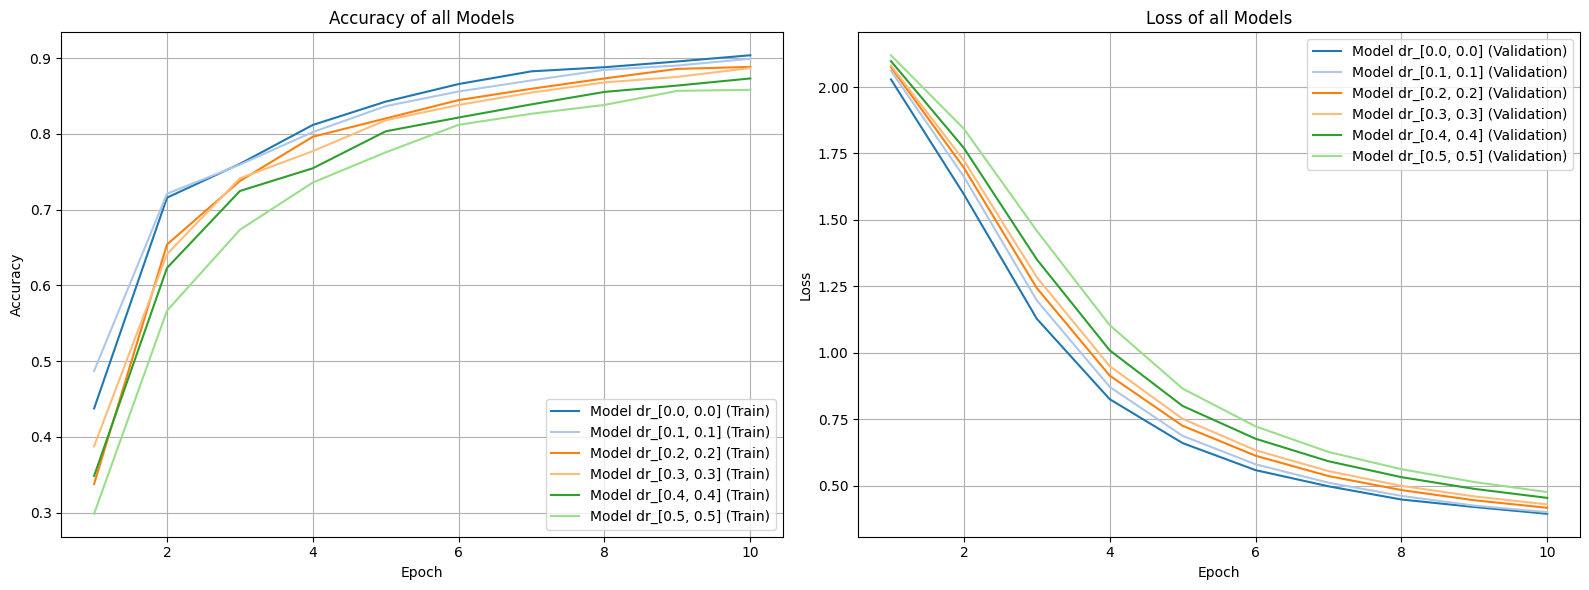

In [76]:
plot_accuracy_and_loss(all_train_accs, all_val_losses, num_epochs, model_names)

In [79]:
# Drop-out

batch_size = 256
in_features = 28 * 28
out_features = 10
hidden_sizes = [512, 512]
hidden_activations = ["relu", "tanh"]
dropout_rates_try = [
    [0.0, 0.0],
    [0.1, 0.1],
    [0.0, 0.1],
    [0.1, 0.0]
    ]
batch_norm = True

optimizer_name = "Adam"
learning_rate = 1e-5
num_epochs = 10
convergence_threshold = 1e-6
lambda_reg = 1e-5


tiny_train_dataset = Subset(train_dataset, range(5000))
tiny_val_dataset = Subset(validation_dataset, range(1250))

tiny_train = DataLoader(dataset=tiny_train_dataset, batch_size=batch_size, shuffle=True)
tiny_val = DataLoader(dataset=tiny_val_dataset, batch_size=int(batch_size/4), shuffle=False)


all_train_losses = []
all_val_losses = []
all_train_accs = []
all_val_accs = []
model_names = []


for dropout_rates in dropout_rates_try:
      model_name = f'dr_{dropout_rates}'
      model_names.append(model_name)

      model1 = MLP(in_features, out_features, hidden_sizes, hidden_activations, dropout_rates, batch_norm)
      train_losses, val_losses, train_accs, val_accs = model1.train_model(
                  tiny_train, tiny_val, optimizer_name, learning_rate, num_epochs, convergence_threshold, lambda_reg)

      all_train_losses.append(train_losses)
      all_val_losses.append(val_losses)
      all_train_accs.append(train_accs)
      all_val_accs.append(val_accs)

Training Started
Epoch 1/10	 Training Loss: 2.2512, Training Acc: 0.1838, Validation Loss: 2.2185, Validation Acc: 0.2384, lr: 1e-05, reg: 1e-05
Epoch 2/10	 Training Loss: 2.0053, Training Acc: 0.3978, Validation Loss: 1.9444, Validation Acc: 0.4688, lr: 1e-05, reg: 1e-05
Epoch 3/10	 Training Loss: 1.7910, Training Acc: 0.5452, Validation Loss: 1.7154, Validation Acc: 0.5768, lr: 1e-05, reg: 1e-05
Epoch 4/10	 Training Loss: 1.6123, Training Acc: 0.6414, Validation Loss: 1.5481, Validation Acc: 0.6376, lr: 1e-05, reg: 1e-05
Epoch 5/10	 Training Loss: 1.4624, Training Acc: 0.6942, Validation Loss: 1.4131, Validation Acc: 0.6816, lr: 1e-05, reg: 1e-05
Epoch 6/10	 Training Loss: 1.3336, Training Acc: 0.7308, Validation Loss: 1.2982, Validation Acc: 0.7088, lr: 1e-05, reg: 1e-05
Epoch 7/10	 Training Loss: 1.2233, Training Acc: 0.7628, Validation Loss: 1.2001, Validation Acc: 0.7368, lr: 1e-05, reg: 1e-05
Epoch 8/10	 Training Loss: 1.1298, Training Acc: 0.7836, Validation Loss: 1.1148, Valid

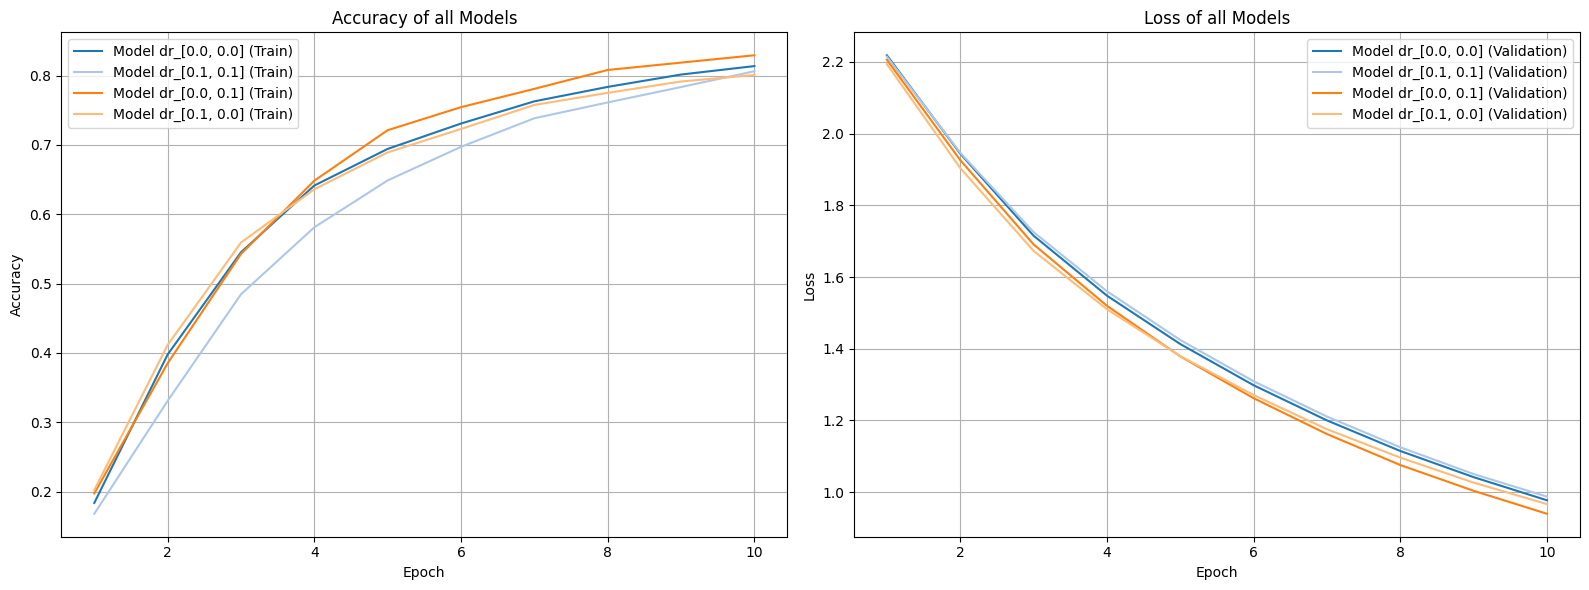

In [80]:
plot_accuracy_and_loss(all_train_accs, all_val_losses, num_epochs, model_names)

In [100]:
# Drop-out

batch_size = 128
in_features = 28 * 28
out_features = 10
hidden_sizes = [512, 512]
hidden_activations_try = [
    ["relu", "tanh"],
    ["leaky_relu", "tanh"],
    ["leaky_relu", "leaky_relu"]]
dropout_rates_try = [0.0, 0.1]
batch_norm = True

optimizer_name = "Adam"
learning_rate = 1e-3
num_epochs = 5
convergence_threshold = 1e-6
lambda_reg = 1e-6


tiny_train_dataset = Subset(train_dataset, range(5000))
tiny_val_dataset = Subset(validation_dataset, range(1250))

tiny_train = DataLoader(dataset=tiny_train_dataset, batch_size=batch_size, shuffle=True)
tiny_val = DataLoader(dataset=tiny_val_dataset, batch_size=int(batch_size/4), shuffle=False)


all_train_losses = []
all_val_losses = []
all_train_accs = []
all_val_accs = []
model_names = []


for hidden_activations in hidden_activations_try:
      model_name = f"af_{'_'.join(hidden_activations)}"
      model_names.append(model_name)

      model1 = MLP(in_features, out_features, hidden_sizes, hidden_activations, dropout_rates, batch_norm)
      train_losses, val_losses, train_accs, val_accs = model1.train_model(
                  tiny_train, tiny_val, optimizer_name, learning_rate, num_epochs, convergence_threshold, lambda_reg)

      all_train_losses.append(train_losses)
      all_val_losses.append(val_losses)
      all_train_accs.append(train_accs)
      all_val_accs.append(val_accs)

Training Started
Epoch 1/5	 Training Loss: 0.4995, Training Acc: 0.8528, Validation Loss: 0.3231, Validation Acc: 0.9128, lr: 0.001, reg: 1e-06
Epoch 2/5	 Training Loss: 0.1824, Training Acc: 0.9510, Validation Loss: 0.2580, Validation Acc: 0.9368, lr: 0.001, reg: 1e-06
Epoch 3/5	 Training Loss: 0.1158, Training Acc: 0.9650, Validation Loss: 0.3087, Validation Acc: 0.9248, lr: 0.001, reg: 1e-06
Epoch 4/5	 Training Loss: 0.0764, Training Acc: 0.9840, Validation Loss: 0.2631, Validation Acc: 0.9440, lr: 0.001, reg: 1e-06
Epoch 5/5	 Training Loss: 0.0686, Training Acc: 0.9810, Validation Loss: 0.2725, Validation Acc: 0.9224, lr: 0.001, reg: 1e-06
Training finished
Training Started
Epoch 1/5	 Training Loss: 0.5035, Training Acc: 0.8470, Validation Loss: 0.3217, Validation Acc: 0.9176, lr: 0.001, reg: 1e-06
Epoch 2/5	 Training Loss: 0.2004, Training Acc: 0.9456, Validation Loss: 0.2935, Validation Acc: 0.9232, lr: 0.001, reg: 1e-06
Epoch 3/5	 Training Loss: 0.1615, Training Acc: 0.9632, Val

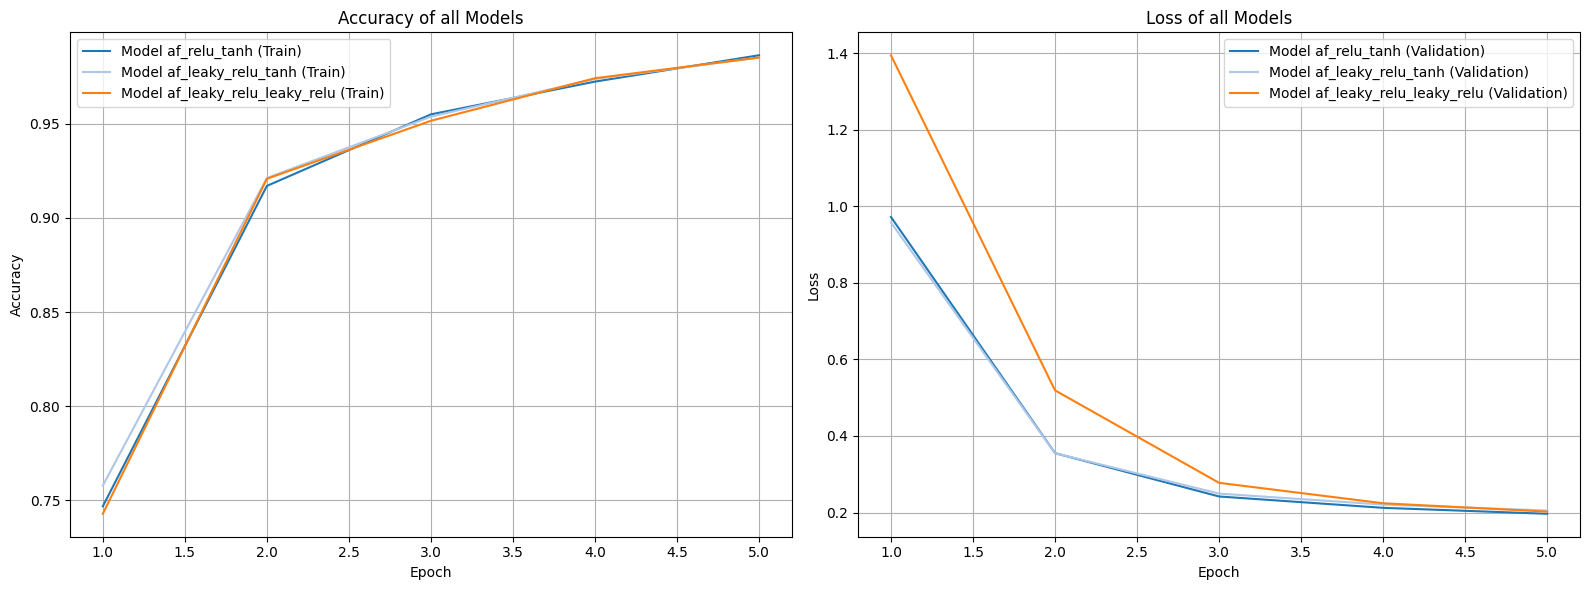

In [99]:
plot_accuracy_and_loss(all_train_accs, all_val_losses, num_epochs, model_names)

In [106]:
# Train and Evaluate Model

batch_size = 32
in_features = 28 * 28
out_features = 10
hidden_sizes = [512, 512]
hidden_activations_try = ["leaky_relu", "tanh"]

dropout_rates_try = [0.0, 0.1]
batch_norm = True

optimizer_name = "Adam"
learning_rate = 1e-4
num_epochs = 50
convergence_threshold = 1e-6
lambda_reg = 1e-5

train_data, test_data, validation_data = load_data(batch_size)

model = MLP(in_features, out_features, hidden_sizes, hidden_activations, dropout_rates, batch_norm)
train_losses, val_losses, train_accs, val_accs = model.train_model(
            train_data, validation_data, optimizer_name, learning_rate, num_epochs, convergence_threshold, lambda_reg)


acc, true_labels, predicted_labels = model.test_model(test_data=test_data)
print(f'Accuracy of the model on the test images: {acc}%')

Training Started


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50	 Training Loss: 0.3417, Training Acc: 0.9146, Validation Loss: 0.1380, Validation Acc: 0.9602, lr: 0.0001, reg: 1e-05
Epoch 2/50	 Training Loss: 0.1454, Training Acc: 0.9619, Validation Loss: 0.0922, Validation Acc: 0.9718, lr: 0.0001, reg: 1e-05
Epoch 3/50	 Training Loss: 0.1041, Training Acc: 0.9739, Validation Loss: 0.0826, Validation Acc: 0.9751, lr: 0.0001, reg: 1e-05
Epoch 4/50	 Training Loss: 0.0825, Training Acc: 0.9805, Validation Loss: 0.0720, Validation Acc: 0.9782, lr: 0.0001, reg: 1e-05
Epoch 5/50	 Training Loss: 0.0703, Training Acc: 0.9833, Validation Loss: 0.0662, Validation Acc: 0.9798, lr: 0.0001, reg: 1e-05
Epoch 6/50	 Training Loss: 0.0594, Training Acc: 0.9861, Validation Loss: 0.0658, Validation Acc: 0.9799, lr: 0.0001, reg: 1e-05
Epoch 7/50	 Training Loss: 0.0549, Training Acc: 0.9876, Validation Loss: 0.0687, Validation Acc: 0.9796, lr: 0.0001, reg: 1e-05
Epoch 8/50	 Training Loss: 0.0471, Training Acc: 0.9900, Validation Loss: 0.0674, Validation Acc:

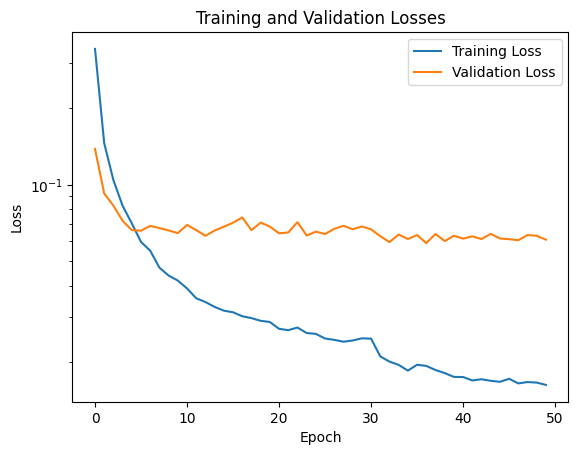

In [107]:
plot_train_val_loss(train_losses, val_losses)

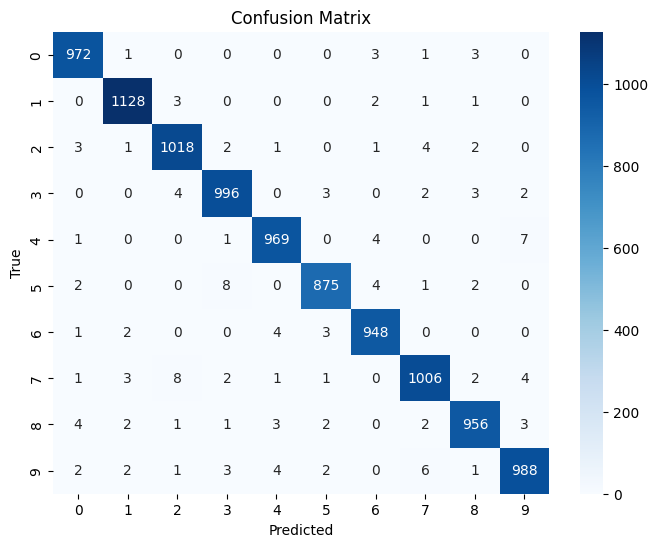

In [114]:
plot_confusion_matrix(true_labels, predicted_labels)